In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.utils.data import Dataset, DataLoader

### 데이터 로드

In [3]:
trans = transforms.Compose([transforms.Resize((224,224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])

In [4]:
trainset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/Colab Notebooks/ml2021/data03/train",
                                           transform = trans)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True)

In [5]:
validationset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/Colab Notebooks/ml2021/data03/valid",
                                           transform = trans)

val_loader = torch.utils.data.DataLoader(validationset, batch_size=8,
                                          shuffle=True)

In [6]:
testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/Colab Notebooks/ml2021/data03/test",
                                           transform = trans)

test_loader = torch.utils.data.DataLoader(testset, batch_size = 8,
                                         shuffle = True)

### 이미지 데이터 확인

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

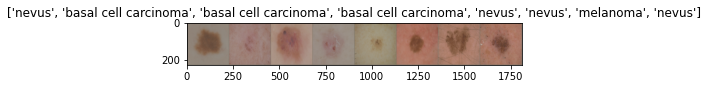

In [8]:
inputs, classes = next(iter(train_loader))
class_names = trainset.classes
# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## googlenet

In [9]:
import torchvision.models as models
net=models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
num_classes = 3
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs,num_classes)
net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.01, weight_decay=1e-6 ,momentum=0.9, nesterov=True)
#optimizer = optim.Adam(net.parameters(), lr = 0.01)

## 학습

In [12]:
def val_eval(val_loader):
  class_correct = list(0. for i in range(1000))
  class_total = list(0. for i in range(1000))
  val_loss = 0.0
  with torch.no_grad():
      for i,data in enumerate(val_loader,0):
          images, labels = data
          images = images.cuda()
          labels = labels.cuda()

          optimizer.zero_grad()
          outputs = net(images)

          loss = criterion(outputs, labels)

          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(labels.size()[0]):
              label = labels[i].item()
              class_correct[label] += c[i].item()
              class_total[label] += 1
              val_loss += loss.item()
  val_acc = sum(class_correct) / sum(class_total) * 100


  print('-------------------------------val loss:', val_loss / len(val_loader))
  print("-------------------------------val Accuracy = ",val_acc)


            

In [13]:
for epoch in range(60):
  total = 0
  running_loss = 0.0
  correct = 0
  for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      inputs, labels = inputs.cuda(), labels.cuda()
      imputs, lables = Variable(inputs.float().cuda()), Variable(labels.float().cuda())
      if i%100 == 0 :
          print("Training...",i)  


      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
        
      max_index = outputs.max(dim=1)[1]
      correct += (max_index == labels).sum().item()
      total += labels.size(0)
      running_loss += loss.item()
      

      if i % len(train_loader) == len(train_loader) - 1:
        print('[epoc: %d, %5d] training loss: %.3f' %(epoch + 1, i + 1, running_loss / len(train_loader)))
        print("Training Accuracy = {}".format(100 * correct / total))
        val_eval(val_loader)
      
print('finish') 
PATH = '/content/drive/MyDrive/Colab Notebooks/ml2021/VGG19.pth'
torch.save(net.state_dict(), PATH)

Training... 0
Training... 100
[epoc: 1,   124] training loss: 0.966
Training Accuracy = 64.17004048582996
-------------------------------val loss: 7.160181489682967
-------------------------------val Accuracy =  69.10569105691057
Training... 0
Training... 100
[epoc: 2,   124] training loss: 0.669
Training Accuracy = 73.98785425101215
-------------------------------val loss: 6.337864234562843
-------------------------------val Accuracy =  70.73170731707317
Training... 0
Training... 100
[epoc: 3,   124] training loss: 0.616
Training Accuracy = 75.20242914979757
-------------------------------val loss: 5.585859679406689
-------------------------------val Accuracy =  65.85365853658537
Training... 0
Training... 100
[epoc: 4,   124] training loss: 0.590
Training Accuracy = 75.40485829959515
-------------------------------val loss: 6.972906452994192
-------------------------------val Accuracy =  67.88617886178862
Training... 0
Training... 100
[epoc: 5,   124] training loss: 0.566
Training Acc

### 정확도 확인

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        images, labels = images.float().cuda(), labels.float().cuda()

        outputs = net(images)
        max_index = outputs.max(dim=1)[1]
        total += labels.size(0)
        correct += (max_index == labels).sum().item()

print('Accuracy of Test: %d %%' % (100 * correct / total))

Accuracy of Test: 77 %
